In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import spearmanr
from scipy.stats import shapiro
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score, roc_curve,auc
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import eli5
import time
from sklearn.linear_model import LogisticRegression

warnings.simplefilter("ignore", UserWarning)


In [2]:
# Reading the datasets
df = pd.read_csv('/Users/hamzasheikh/Downloads/GiveMeSomeCredit/cs-training.csv', index_col=0)
testing_data = pd.read_csv('/Users/hamzasheikh/Downloads/GiveMeSomeCredit/cs-test.csv', index_col=0)


In [3]:
df.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   
3                                2                        1   
4                                5                        0   
5                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                             6                                     0   
2                             0                                     0   
3                             0                                     0   
4                             0                                     0   
5                             1                                     0   

   NumberOfDependents  
1                 2.0  
2                 1.0  
3                 0.0  
4                 0.0  
5                 0.0

In [4]:
df.shape, testing_data.shape

((150000, 11), (101503, 11))

In [5]:
# Target variable in test data has just nan values
# They are to be predicted so we can't find performance on this testing dataset

testing_data["SeriousDlqin2yrs"].unique()

array([nan])

In [6]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

> There are null values in monthly income and number of dependents.

In [7]:
df.describe()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines            age  \
count     150000.000000                         150000.000000  150000.000000   
mean           0.066840                              6.048438      52.295207   
std            0.249746                            249.755371      14.771866   
min            0.000000                              0.000000       0.000000   
25%            0.000000                              0.029867      41.000000   
50%            0.000000                              0.154181      52.000000   
75%            0.000000                              0.559046      63.000000   
max            1.000000                          50708.000000     109.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         150000.000000  150000.000000   1.202690e+05   
mean                               0.421033     353.005076   6.670221e+03   
std                                4.192781    2037.818523   1.438467e+04   
min                                0.000000       0.000000   0.000000e+00   
25%                                0.000000       0.175074   3.400000e+03   
50%                                0.000000       0.366508   5.400000e+03   
75%                                0.000000       0.868254   8.249000e+03   
max                               98.000000  329664.000000   3.008750e+06   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                    150000.000000            150000.000000   
mean                          8.452760                 0.265973   
std                           5.145951                 4.169304   
min                           0.000000                 0.000000   
25%                           5.000000                 0.000000   
50%                           8.000000                 0.000000   
75%                          11.000000                 0.000000   
max                          58.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                 150000.000000                         150000.000000   
mean                       1.018240                              0.240387   
std                        1.129771                              4.155179   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                       54.000000                             98.000000   

       NumberOfDependents  
count       146076.000000  
mean             0.757222  
std              1.115086  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max             20.000000

> Stasticial distribution can be seen here for all the variables.

In [8]:
# Lets check for null value percentage in all the columns
print("Percentage of null values column wise:")
(df.isnull().sum()/df.shape[0])*100

Percentage of null values column wise:


SeriousDlqin2yrs                         0.000000
RevolvingUtilizationOfUnsecuredLines     0.000000
age                                      0.000000
NumberOfTime30-59DaysPastDueNotWorse     0.000000
DebtRatio                                0.000000
MonthlyIncome                           19.820667
NumberOfOpenCreditLinesAndLoans          0.000000
NumberOfTimes90DaysLate                  0.000000
NumberRealEstateLoansOrLines             0.000000
NumberOfTime60-89DaysPastDueNotWorse     0.000000
NumberOfDependents                       2.616000
dtype: float64

> almost 20% null values are there in Monthlyincome and 2.61% in number of dependents.

> We will be imputing them on the basis of what type of distribution they have.

## User defined functions


In [9]:
# You can change inclination, figure size anything by just passing the parameter values
# This function would give you counts for each of the labels, you just have to pass the dataframe, column name, how do you want to see vertical or horizontal
def plot_univariate(data, col, inclination, figsize, color):
    
    #setting subplots and figure size
    fig, ax = plt.subplots(figsize=(figsize))
    
    # Defining inclination of the plot
    if inclination == "horizontal":
        
        data[col].value_counts().plot(kind = "barh",color = color,  ax = ax);
        plt.title(f"{col} Vs Frequency"); 
        plt.xlabel("Frequencies");
        plt.ylabel("Labels");
        plt.xticks(rotation = 90);
        plt.show()
        print(f'Feature "{col}" has highest frequency for the class: {data[col].value_counts().index.values[0]}')
        print(f'Feature "{col}" has lowest frequency for the class: {data[col].value_counts().index.values[-1]}')

    else:
        data[col].value_counts().plot(kind = "bar",color = color, ax = ax);
        plt.title(f"{col} Vs Frequency"); 
        plt.ylabel("Frequencies");
        plt.xlabel("Labels");
        plt.yticks(rotation = 90);
        plt.show()
        print(f'Feature "{col}" has highest frequency for the class: {data[col].value_counts().index.values[0]}')
        print(f'Feature "{col}" has lowest frequency for the class: {data[col].value_counts().index.values[-1]}')
    
def check_distribution(df):
    for column in df.columns:
        print(f"Skewness for the column is: {column}", df[column].skew())
        if  df[column].skew()>0:
            print("Distribution is right skewed.")
        elif  df[column].skew()<0:
            print("Distribution is left skewed.")
        else:
            print("Normally distributed.")

        sns.displot(df[column], kde = True)
        plt.show()
    
def check_normality(data, col):
    stats, p = shapiro(data[col].values)

    print(f"Value of statistic is : {stats}, and p-value is: {p}")
    print()

    if p > 0.05:
        print(f"'{col}' is normally distributed. Since here is greater than a 5% chance of a result as extreme as the sample result when the null hypothesis is true.(fail to reject H0)")

    else:
        print(f"'{col}' is not normally distributed. Hence, (reject H0), alternate hypothesis is true.")


def train_eval_classifier(clf, X, y, optimized = False ):

    start = time.time()

    # Defining the folds
    kf = StratifiedKFold(n_splits=5)

    fold = 0
    
    # These lists would contain all the scores across 5 folds, we would be taking a mean of them
    roc_train, f1_train, precision_train, recall_train, accuracy_train = [], [], [], [], []
    roc_test, f1_test, precision_test, recall_test, accuracy_test = [], [], [], [], []
    
    for df_index, test_index in kf.split(X, y):

        X_df, y_df, X_test, y_test = X.iloc[df_index], y.iloc[df_index], X.iloc[test_index], y.iloc[test_index]

        # Scaling the data
        scaler = StandardScaler()
        X_df = scaler.fit_transform(X_df)
        X_test = scaler.transform(X_test)
        
        # creating smotes object
        smote = SMOTE()

        # Applying smote to df data
        X_df, y_df = smote.fit_resample(X_df, y_df)
        
        #Fitting the model
        clf.fit(X_df, y_df ) 
        
        y_df_pred = clf.predict(X_df)
        y_test_pred = clf.predict(X_test)

        
        # Calculating Roc score
        roc_train.append(roc_auc_score(y_df, clf.predict_proba(X_df)[:, 1]))    
        # Calculating fscore, precision & recall 
        f1_train.append(f1_score(y_df, y_df_pred))
        precision_train.append(precision_score(y_df, y_df_pred))
        recall_train.append(recall_score(y_df, y_df_pred))
        #Calculating accuracy
        accuracy_train.append(accuracy_score(y_df,y_df_pred))
        
        
        # Calculating Roc score
        roc_test.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))    
        # Calculating fscore, precision & recall 
        f1_test.append(f1_score(y_test, y_test_pred))
        precision_test.append(precision_score(y_test, y_test_pred))
        recall_test.append(recall_score(y_test, y_test_pred))
        #Calculating accuracy
        accuracy_test.append(accuracy_score(y_test,y_test_pred))
        
        print("Fold: ", fold + 1, ' done')
        fold+=1

    print()
    
    print("Mean Accuracy on train set is: ", np.mean(accuracy_train, axis = 0))
    print("Mean Accuracy on test set is: ", np.mean(accuracy_test, axis = 0))

    print()
    print("Mean Precision on train set is:", np.mean(precision_train, axis = 0))
    print("Mean Precision on test set is:", np.mean(precision_test, axis = 0))
    print()
    print("Mean Recall on train set is:",  np.mean(recall_train, axis = 0))
    print("Mean Recall on test set is:",  np.mean(recall_test, axis = 0))
    print()
    print("Mean F score on train set is:", np.mean(f1_train , axis = 0))
    print("Mean F score on test set is:", np.mean(f1_test , axis = 0))
    print()
    print('Mean Train ROC is:',np.mean(roc_train, axis = 0) )
    print('Mean Test ROC is:',np.mean(roc_test, axis = 0) )
    print()
    print()
     
    # displaying confusion matrix
    conf = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf, annot=True, fmt='g'); 
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Confusion Matrix'); 

    
    # Create ROC AUC curve
    fig, [ax1, ax2] = plt.subplots(1, 2,  figsize=(6, 4 ));

    fpr, tpr, _ = roc_curve(y_df, clf.predict_proba(X_df)[:, 1])
    ax1.plot(fpr, tpr);
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate');
    ax1.set_title('Train ROC-AUC Curve');

    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    ax2.plot(fpr, tpr);
    ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate');
    ax2.set_title('Test ROC-AUC Curve');
    plt.tight_layout(pad=0.3)
    
    fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 1,  figsize=(5, 10 ));
    ax1.scatter(["Train Set","Test Set"], [np.mean(accuracy_train, axis = 0), np.mean(accuracy_test, axis = 0)])
    ax1.set_title("Accuracy for train and test sets!")
    ax2.scatter(["Train Set","Test Set"], [np.mean(precision_train, axis = 0), np.mean(precision_test, axis = 0)])
    ax2.set_title("Precision for train and test sets!")
    plt.tight_layout(pad=0.3)
    ax3.scatter(["Train Set","Test Set"], [np.mean(recall_train, axis = 0), np.mean(recall_test, axis = 0)])
    ax3.set_title("Recall for train and test sets!")
    ax4.scatter(["Train Set","Test Set"], [np.mean(roc_train, axis = 0), np.mean(roc_test, axis = 0)])
    ax4.set_title("ROC-AUC for train and test sets!")
    ax5.scatter(["Train Set","Test Set"], [np.mean(f1_train , axis = 0), np.mean(f1_test , axis = 0)])
    ax5.set_title("F-Score for train and test sets!")
    
    plt.tight_layout(pad=0.5)

    print(f'Total time taken: {time.time() - start}')
    
    # Feature interpretation showing which feature has contribited how much
    try:
        eli5.show_weights(clf, top= 20, feature_names = list(X.columns))
    except:
        print()
        
    key = str(clf).split("(")[0]
    
    if optimized:
        key = key+"_optimized"
    
    
    data = [np.mean(accuracy_train, axis = 0), np.mean(accuracy_test, axis = 0),
           np.mean(precision_train, axis = 0), np.mean(precision_test, axis = 0),
           np.mean(recall_train, axis = 0), np.mean(recall_test, axis = 0),
           np.mean(f1_train, axis = 0), np.mean(f1_test, axis = 0),
           np.mean(roc_train, axis = 0), np.mean(roc_test, axis = 0)]

    data.extend([key])

    results_df = pd.DataFrame(data = [data],  columns = ["accuracy_train", "accuracy_test", "precision_train", "precision_test",
                                                   "recall_train", "recall_test", "f1_train", "f1_test", "roc_train", "roc_test","model_name"])
    
    results_df =  results_df.set_index("model_name")
    
    #Finally returning the fitted model
    return clf, results_df

def gridsearchit(reg, grid, X_df, X_test, y_df, y_test):
    grid_ = GridSearchCV(estimator = reg, param_grid = grid, cv = 2, n_jobs=4, verbose = 0, scoring='roc_auc')
    grid_.fit(X_df, y_df)
    print(f"Results from Grid Search: " )
    print(f"\nThe best estimator across ALL searched params for {str(reg).split('(')[0]}\n", grid_.best_estimator_)
    print(f"\nThe best score across ALL searched params for {str(reg).split('(')[0]}", grid_.best_score_)
    print(f"\nThe best parameters across ALL searched params for {str(reg).split('(')[0]}:\n", grid_.best_params_)
    print()
    # Getting the best estimator
    optimized_model = grid_.best_estimator_
    return optimized_model

# compute the vif for all given features
def compute_vif(df, features):
    
    X = df[features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

## EDA

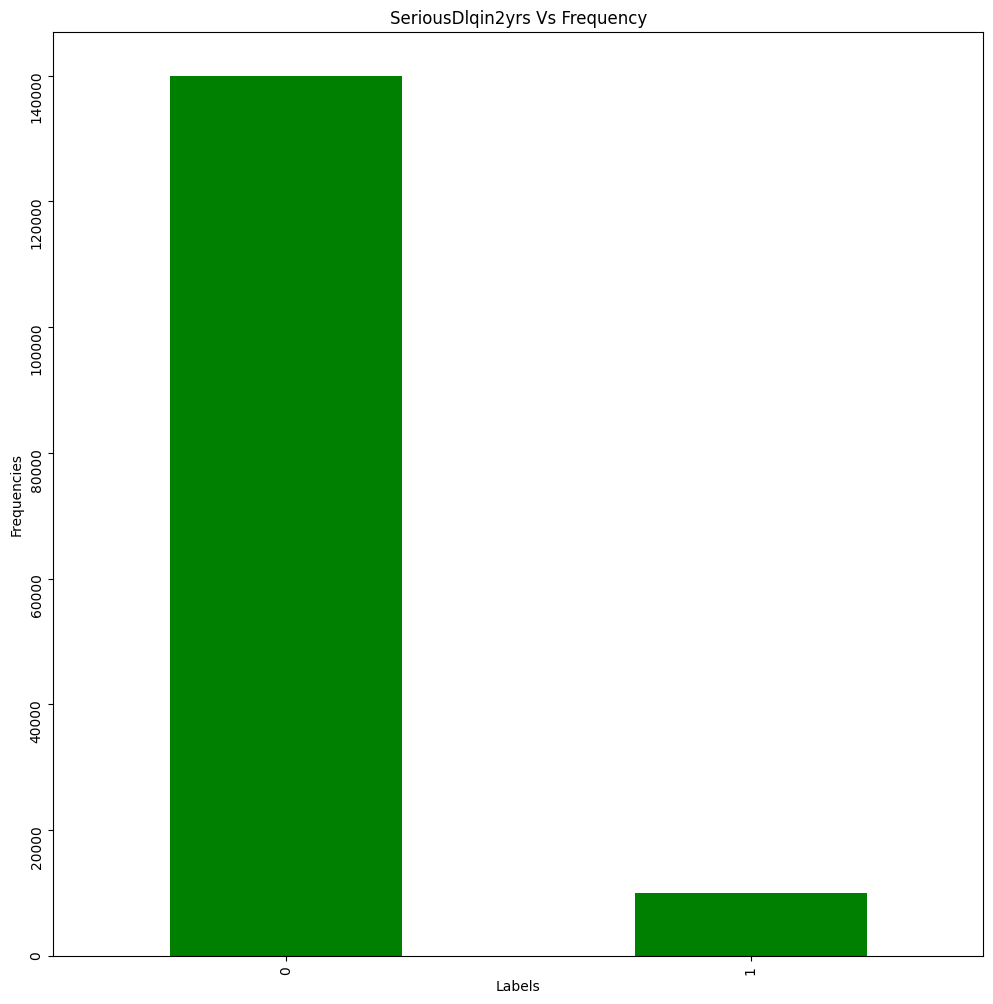

Feature "SeriousDlqin2yrs" has highest frequency for the class: 0
Feature "SeriousDlqin2yrs" has lowest frequency for the class: 1


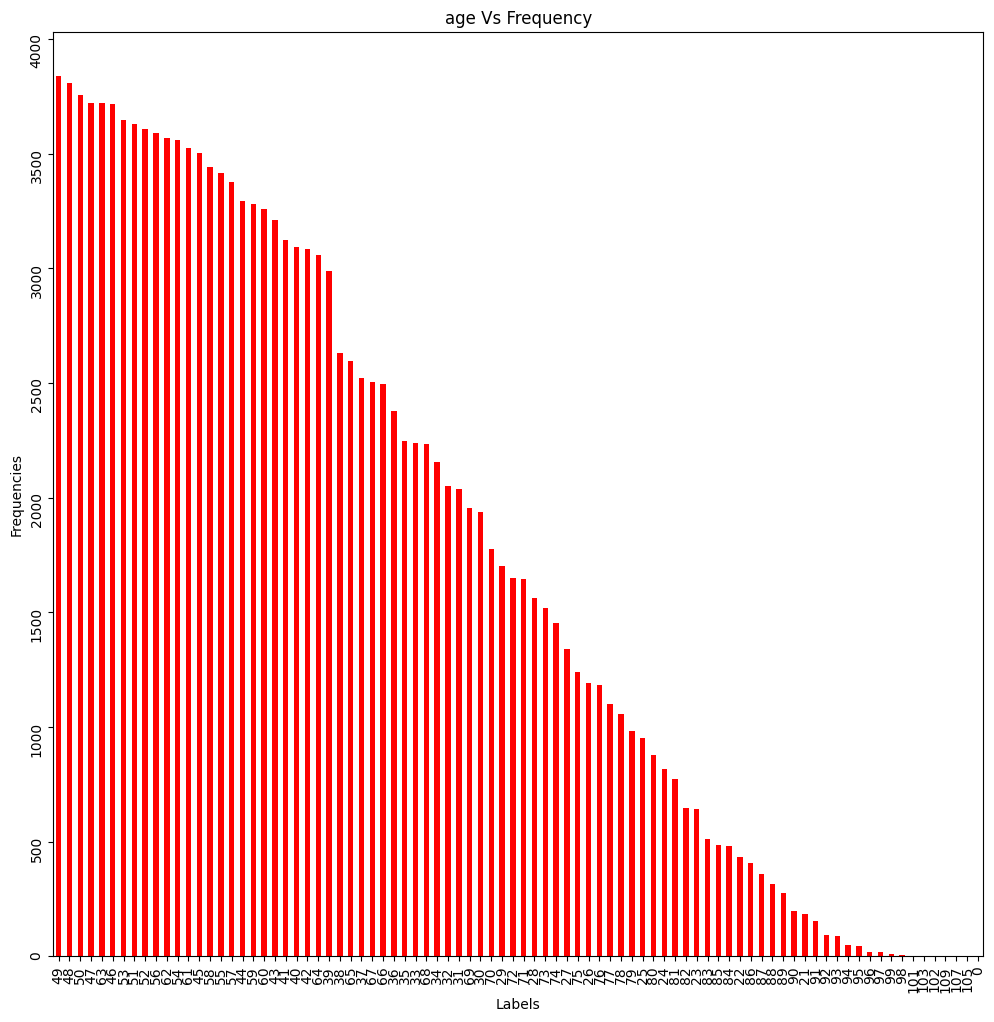

Feature "age" has highest frequency for the class: 49
Feature "age" has lowest frequency for the class: 0


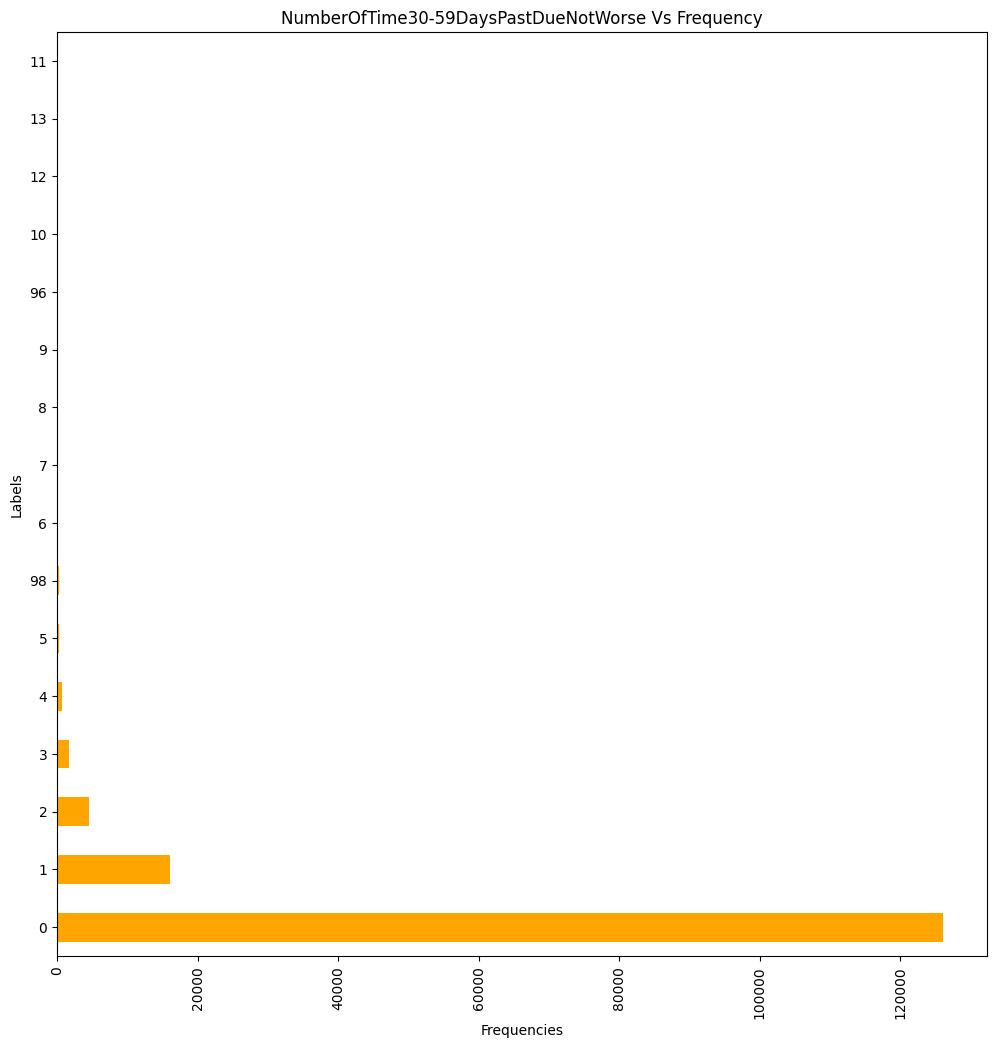

Feature "NumberOfTime30-59DaysPastDueNotWorse" has highest frequency for the class: 0
Feature "NumberOfTime30-59DaysPastDueNotWorse" has lowest frequency for the class: 11


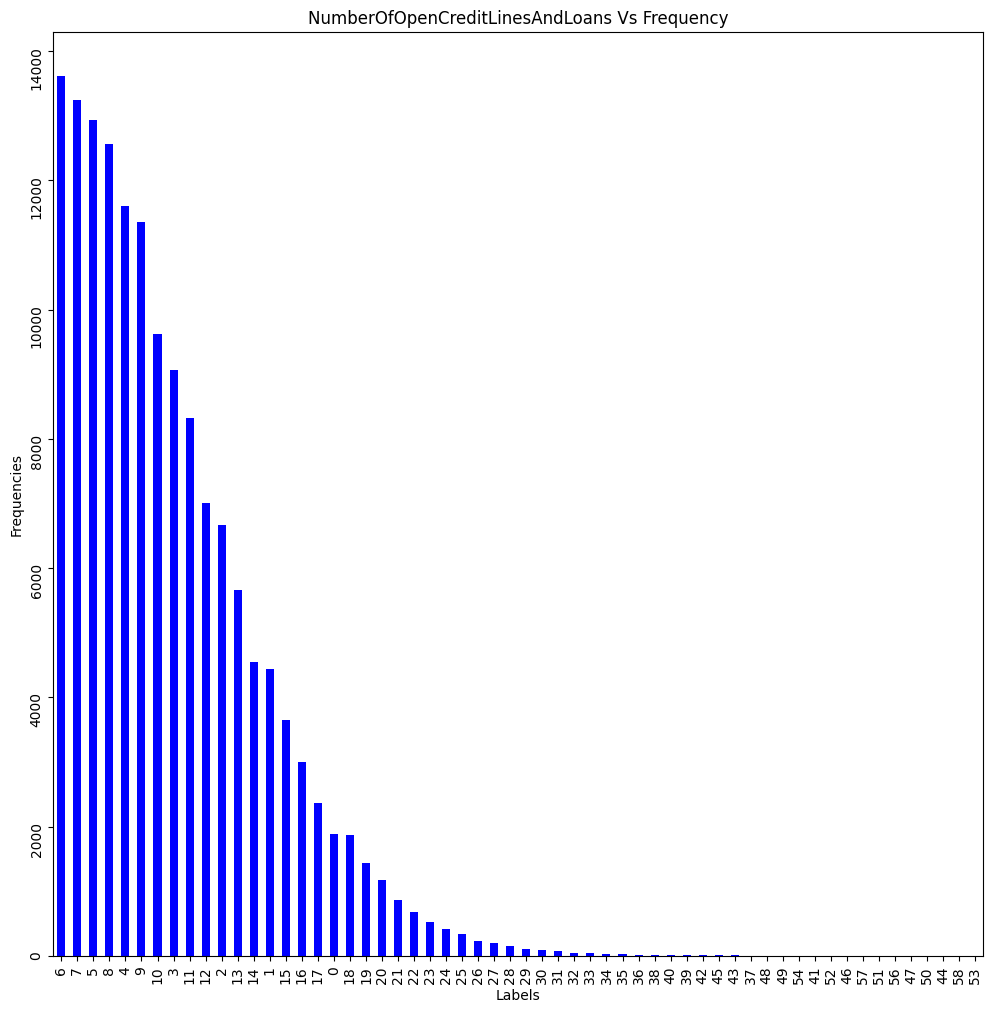

Feature "NumberOfOpenCreditLinesAndLoans" has highest frequency for the class: 6
Feature "NumberOfOpenCreditLinesAndLoans" has lowest frequency for the class: 53


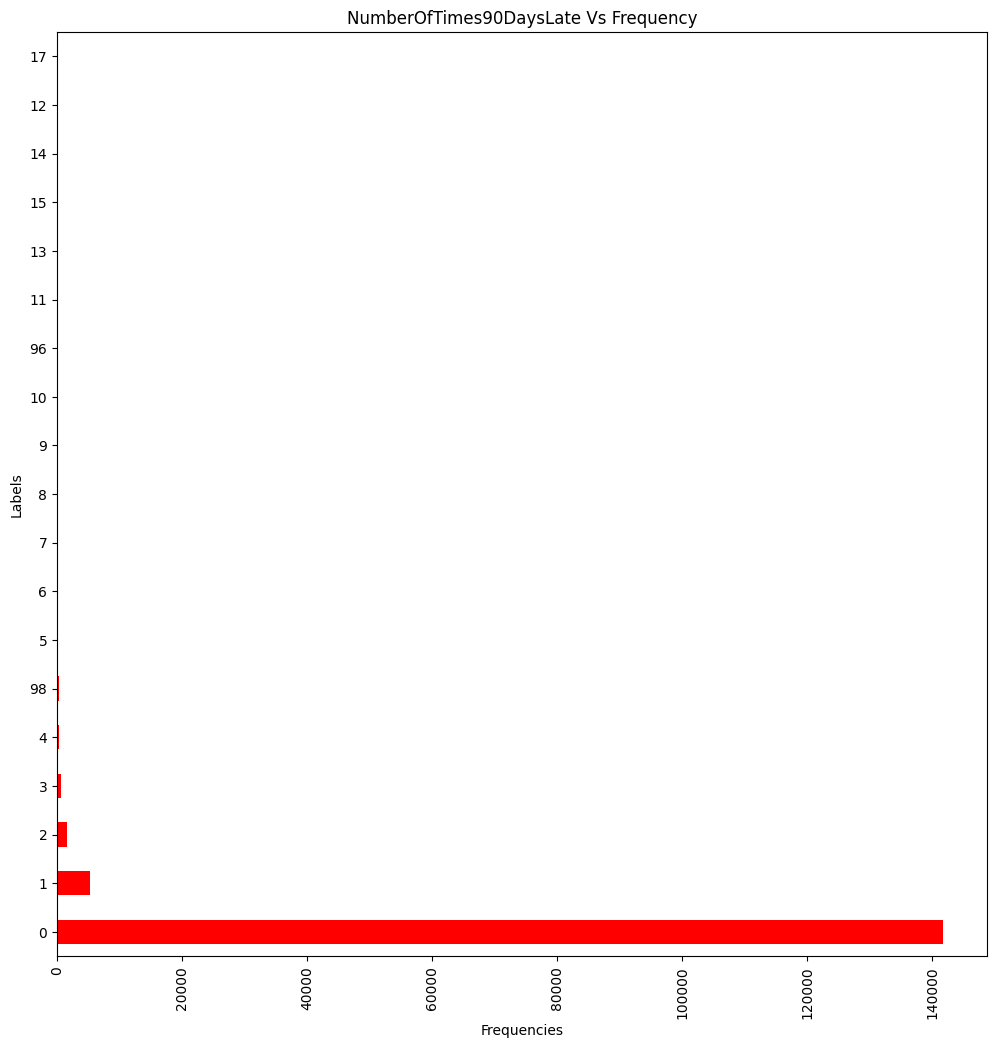

Feature "NumberOfTimes90DaysLate" has highest frequency for the class: 0
Feature "NumberOfTimes90DaysLate" has lowest frequency for the class: 17


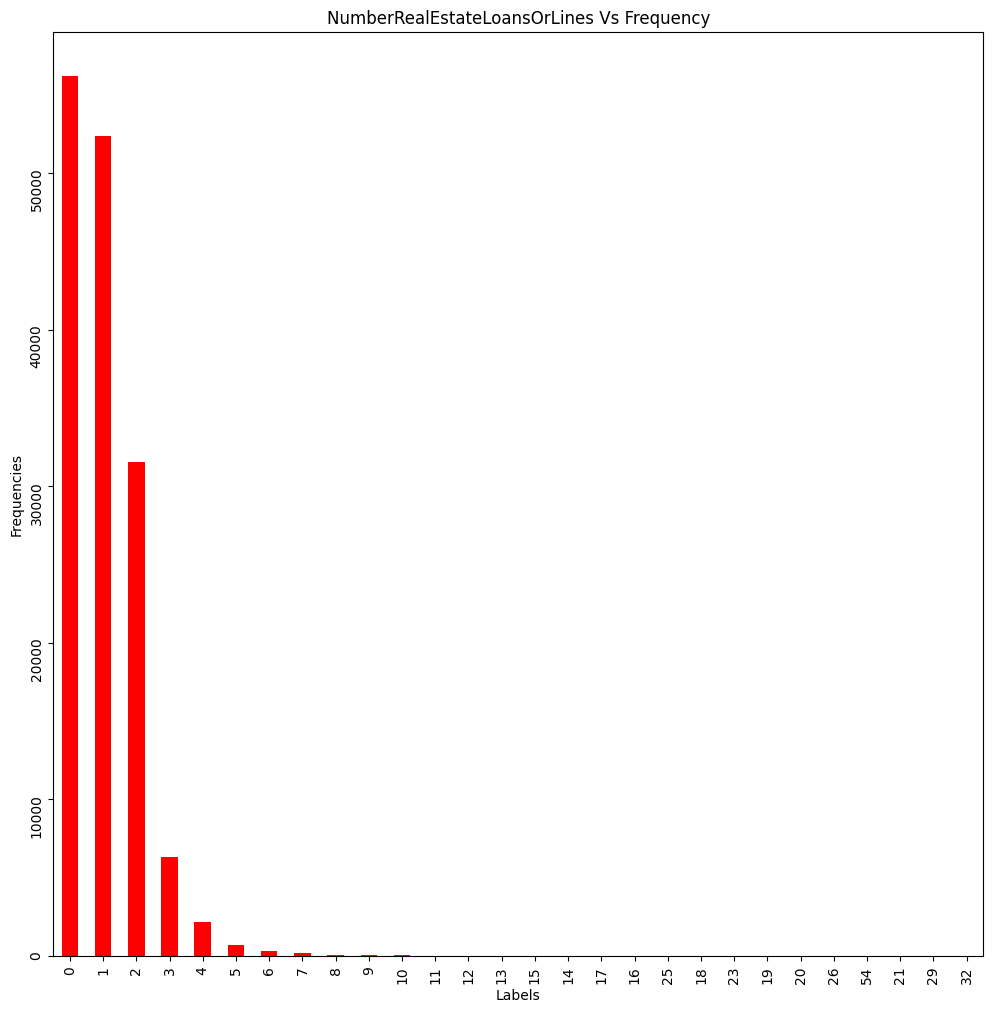

Feature "NumberRealEstateLoansOrLines" has highest frequency for the class: 0
Feature "NumberRealEstateLoansOrLines" has lowest frequency for the class: 32


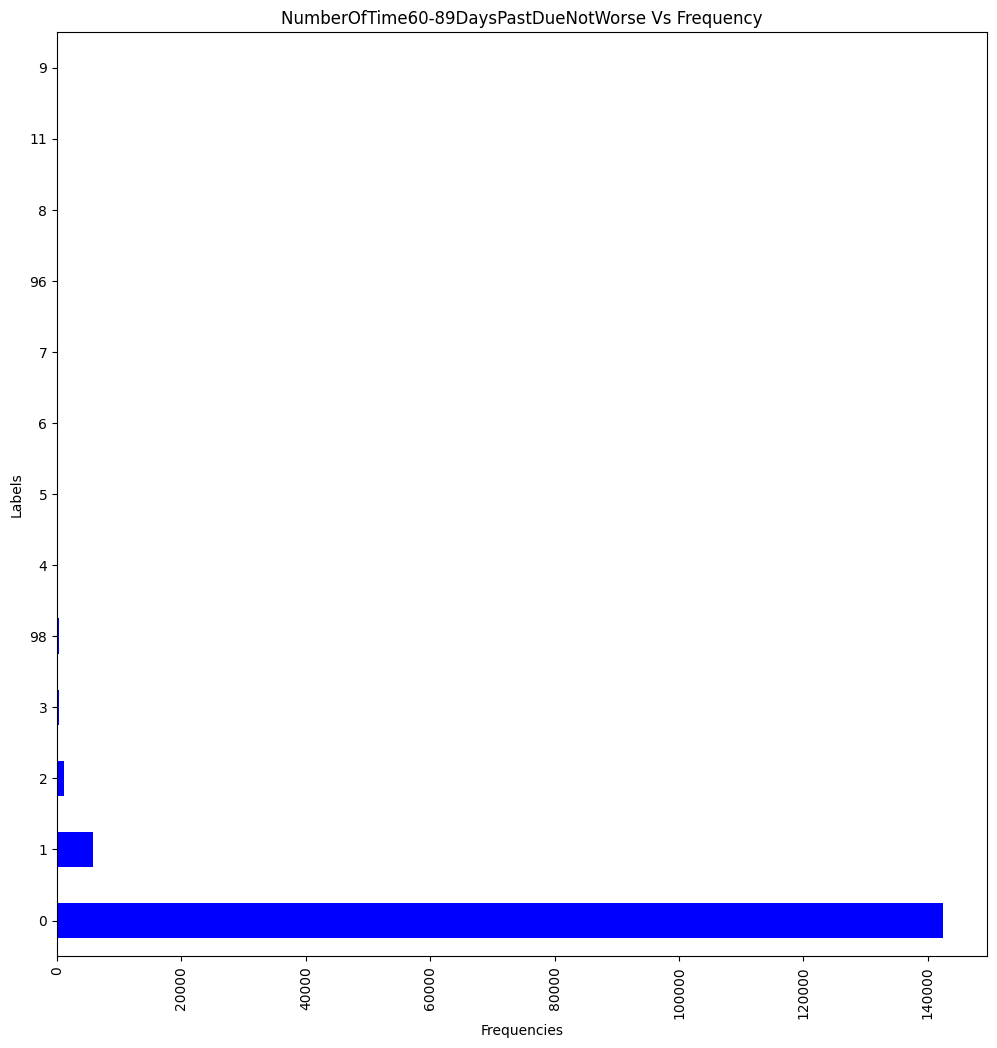

Feature "NumberOfTime60-89DaysPastDueNotWorse" has highest frequency for the class: 0
Feature "NumberOfTime60-89DaysPastDueNotWorse" has lowest frequency for the class: 9


In [10]:
# Frequency for every label and variable can be seen in this plot

# setting color and orientation for the plots, it would randomly choose the color and orientation
color = ["r", "y", "g", "b", "orange", "pink", "b"]
orientation = ["horizontal", "vertical"]

for c, col in enumerate([col for col in df.columns if df[col].dtype=="int"]):
    plot_univariate(df, col, orientation[random.randint(0, len(orientation)-1)], (12,12), color[random.randint(0, len(color)-1)])


### Doing a  Normality test on our features to check if the feature is normally distributed or not.

In [11]:
check_normality(df, "RevolvingUtilizationOfUnsecuredLines")

Value of statistic is : 0.0070040225982666016, and p-value is: 0.0

'RevolvingUtilizationOfUnsecuredLines' is not normally distributed. Hence, (reject H0), alternate hypothesis is true.


In [12]:

check_normality(df, "DebtRatio")

Value of statistic is : 0.11845004558563232, and p-value is: 0.0

'DebtRatio' is not normally distributed. Hence, (reject H0), alternate hypothesis is true.


In [13]:
check_normality(df, "MonthlyIncome")

Value of statistic is : nan, and p-value is: 1.0

'MonthlyIncome' is normally distributed. Since here is greater than a 5% chance of a result as extreme as the sample result when the null hypothesis is true.(fail to reject H0)


Skewness for the column NumberOfDependents is: 1.5882423788858833


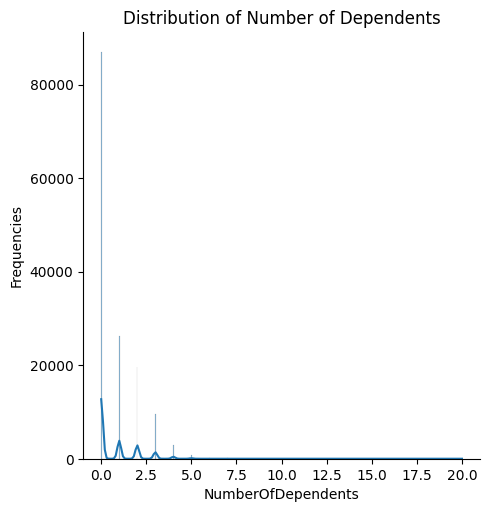

In [14]:
# Distribution of column number of dependents and skewness
sns.displot(df["NumberOfDependents"], kde = True);
plt.title("Distribution of Number of Dependents");
plt.xlabel("NumberOfDependents");
plt.ylabel("Frequencies");
print("Skewness for the column NumberOfDependents is:", df["NumberOfDependents"].skew())

> This is a right skewed distribution.

Skewness for the column MonthlyIncome is: 114.0403179452332


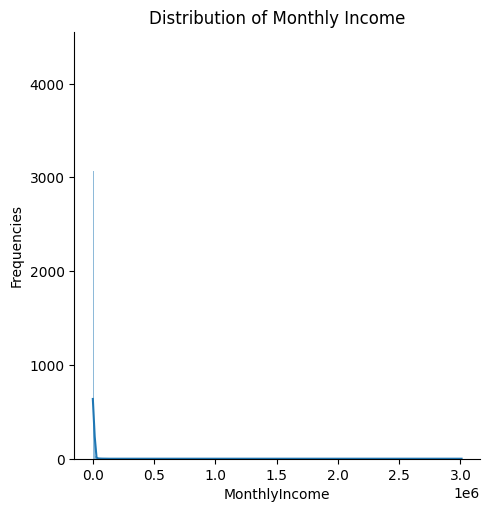

In [15]:

# Distribution of column Monthly Income and skewness
sns.displot(df["MonthlyIncome"], kde = True);
plt.title("Distribution of Monthly Income");
plt.xlabel("MonthlyIncome");
plt.ylabel("Frequencies");
print("Skewness for the column MonthlyIncome is:", df["MonthlyIncome"].skew())

> This is a right skewed distribution.

In [16]:
## Since both columns are skewed, lets proceed imputing their null values with their median value

df["MonthlyIncome"].fillna(df["MonthlyIncome"].median(), inplace = True)
df["NumberOfDependents"].fillna(df["NumberOfDependents"].median(), inplace = True)

> Now we don't have null values in any column.

> We would be modelling on tree based models which are not affected by outliers thus we can skip removal of outliers.

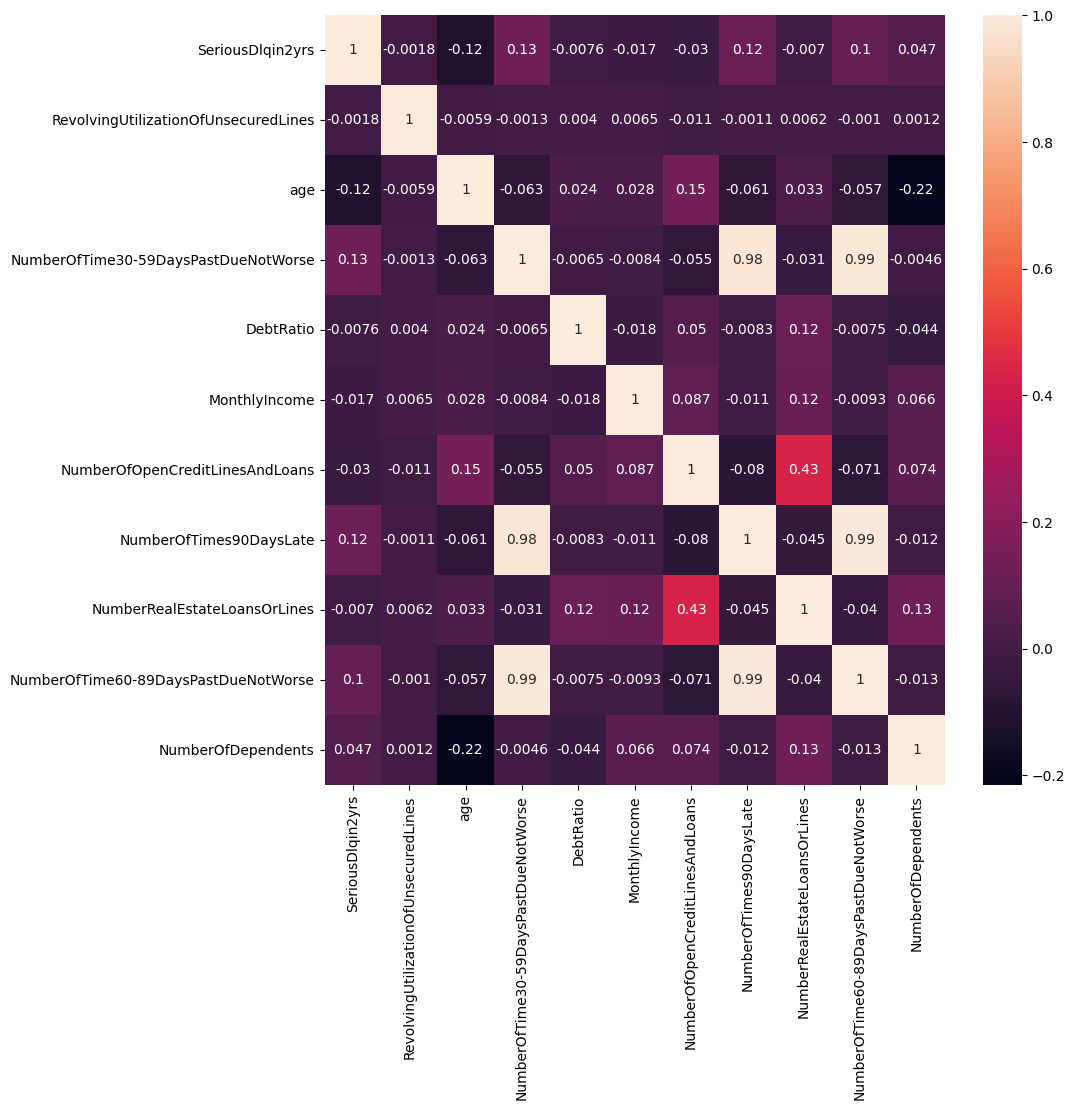

In [17]:
fig, ax = plt.subplots(figsize=(10,10));
sns.heatmap(df.corr(), annot = True, ax = ax);


> NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse are crrelated and have a very strong correlation. That is greater than 0.9.

> There is no point in sending in correlated features to the model. Lets drop the features. But lets not do that blatantly instead kets check VIF first.

In [18]:
# The one giving the greatest VIF, we would keep on removing it till the interaction decreases
compute_vif(df, ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"])

/var/folders/1b/6_jlthxx5rj3h57f1wxl2r9c0000gn/T/ipykernel_2496/2099557232.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Variable        VIF
0  NumberOfTime30-59DaysPastDueNotWorse  40.220761
1               NumberOfTimes90DaysLate  72.341097
2  NumberOfTime60-89DaysPastDueNotWorse  91.128082

In [19]:
# VIF has dropped, we need to get it under 5
compute_vif(df, ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate"])

/var/folders/1b/6_jlthxx5rj3h57f1wxl2r9c0000gn/T/ipykernel_2496/2099557232.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Variable        VIF
0  NumberOfTime30-59DaysPastDueNotWorse  30.744857
1               NumberOfTimes90DaysLate  30.744857

In [20]:
# Now its under 5, thus we would have to drop those 2 features.
compute_vif(df, ["NumberOfTime30-59DaysPastDueNotWorse"])

/var/folders/1b/6_jlthxx5rj3h57f1wxl2r9c0000gn/T/ipykernel_2496/2099557232.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Variable  VIF
0  NumberOfTime30-59DaysPastDueNotWorse  1.0

**IMP:**
    
> Multicollinearity is not an issue with tree based models, we can continue without dropping these variables. The above part was just for the analysis.

In [21]:
df.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   
3                                2                        1   
4                                5                        0   
5                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                             6                                     0   
2                             0                                     0   
3                             0                                     0   
4                             0                                     0   
5                             1                                     0   

   NumberOfDependents  
1                 2.0  
2                 1.0  
3                 0.0  
4                 0.0  
5                 0.0

In [22]:
#the range for the features are not uniform, we would have to perform some scaling technique
# Before that lets do a train test split, so as to avoid data leakage, we would fit-transform on the train data and transform on the test data
# Split percentage here is 80:20 with 80 going to train
# But all of this would be done internally on every fold while we do a cross validation

# We would be doing cross validation to get an average result(on 5 folds) rather than on just 1 fold (normal train-test split)

X, y = df.drop("SeriousDlqin2yrs", axis = 1), df["SeriousDlqin2yrs"]

> Now we are ready for modelling.

## Modelling

### Decision Tree Baseline Model

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.9997954977129615
Mean Accuracy on test set is:  0.8624400000000001

Mean Precision on train set is: 0.9998481718785909
Mean Precision on test set is: 0.1953748502595299

Mean Recall on train set is: 0.9997428093820713
Mean Recall on test set is: 0.3391197479879563

Mean F score on train set is: 0.9997954868384014
Mean F score on test set is: 0.24791092037591547

Mean Train ROC is: 0.9999998653357338
Mean Test ROC is: 0.619921021713469


Total time taken: 7.798851013183594


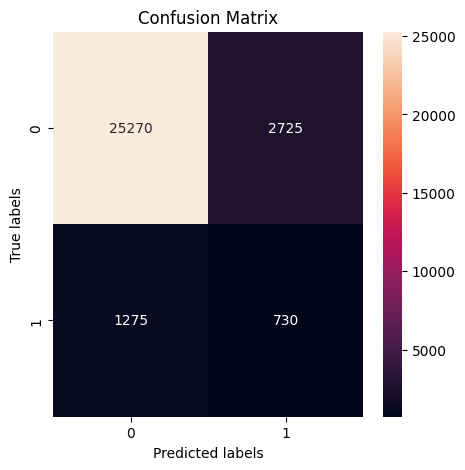

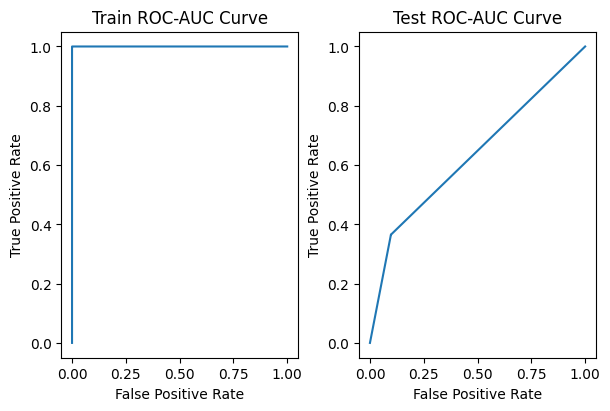

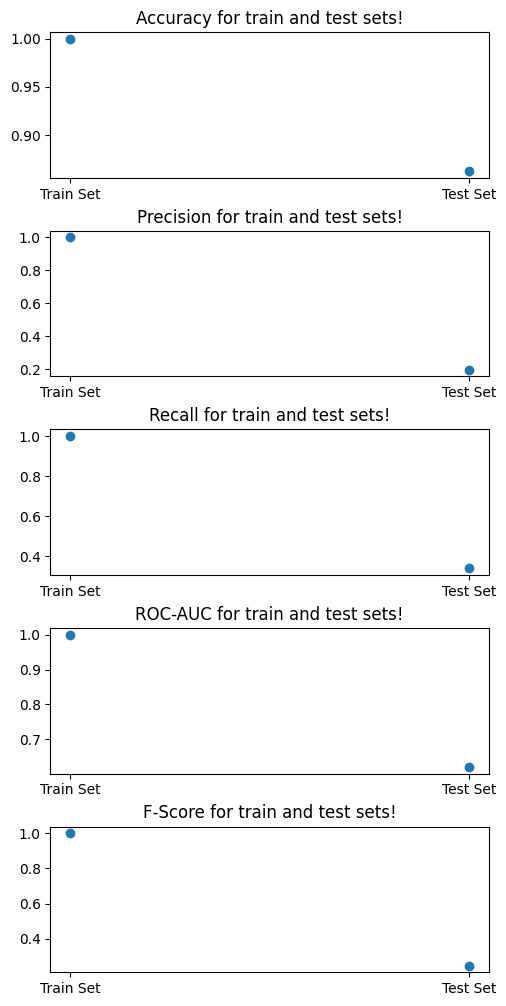

In [23]:
# Training and evaluating an Decision Tree classifier here

dt_clf, dt_results = train_eval_classifier(DecisionTreeClassifier(random_state = 0), X,y, False )

In [47]:
eli5.show_weights(dt_clf, top= 20, feature_names = list(X.columns))


### Tuning Decision Tree

In [41]:
# We are taking the baseline Decision tree Model that we trained and we will be tuning it using grid search
# Later on we again check the results on our tuned model

dt_grid = { 'max_depth' : np.arange(1, 25)  }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Before smote: ", Counter(y_train))
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After smote: ", Counter(y_train))

dt_opt = gridsearchit(dt_clf, dt_grid, X_train, X_test, y_train, y_test)

Before smote:  Counter({0: 111992, 1: 8008})
After smote:  Counter({0: 111992, 1: 111992})
Results from Grid Search: 

The best estimator across ALL searched params for DecisionTreeClassifier
 DecisionTreeClassifier(max_depth=13, random_state=0)

The best score across ALL searched params for DecisionTreeClassifier 0.9258489204409359

The best parameters across ALL searched params for DecisionTreeClassifier:
 {'max_depth': 13}



### Evaluating Optimized Decision Tree:

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.8713895061805476
Mean Accuracy on test set is:  0.8531866666666665

Mean Precision on train set is: 0.8865134194741726
Mean Precision on test set is: 0.23258020921473405

Mean Recall on train set is: 0.8520457118502565
Mean Recall on test set is: 0.5171524827015214

Mean F score on train set is: 0.868847868369895
Mean F score on test set is: 0.3204056713034242

Mean Train ROC is: 0.9504277412739928
Mean Test ROC is: 0.7616998344580557


Total time taken: 6.318386793136597


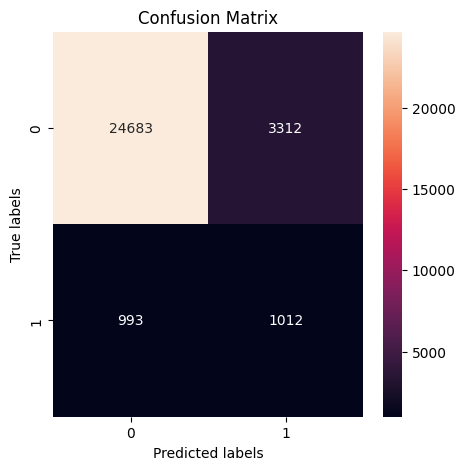

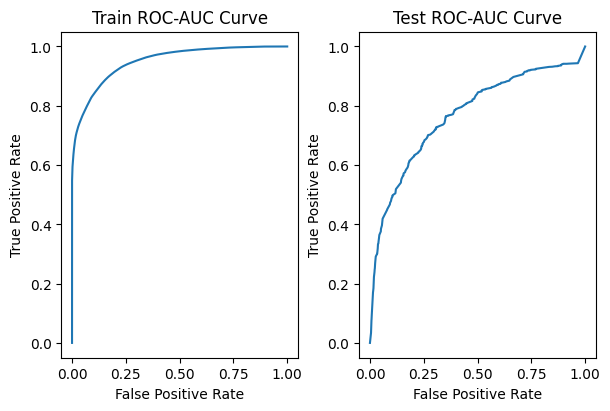

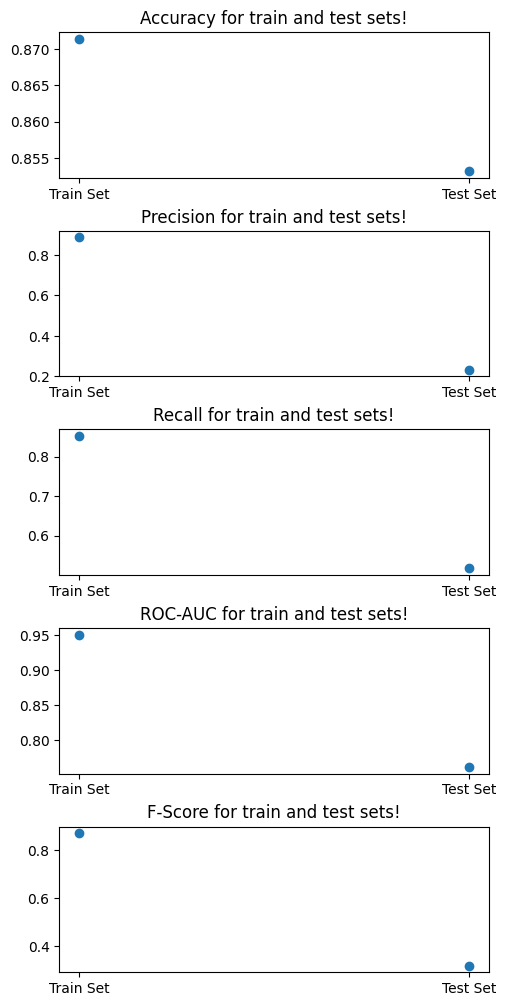

In [25]:
dt_opt, dt_opt_results = train_eval_classifier(dt_opt, X,y, True )

In [48]:
eli5.show_weights(dt_opt, top= 20, feature_names = list(X.columns))


### XGBoost Baseline Model

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.9587137601902913
Mean Accuracy on test set is:  0.9310133333333332

Mean Precision on train set is: 0.982611252591826
Mean Precision on test set is: 0.472111971052831

Mean Recall on train set is: 0.9339555906896603
Mean Recall on test set is: 0.26730571378134915

Mean F score on train set is: 0.9576656268452453
Mean F score on test set is: 0.34124542014753134

Mean Train ROC is: 0.9897437091646966
Mean Test ROC is: 0.8412414101716041


Total time taken: 29.76730704307556


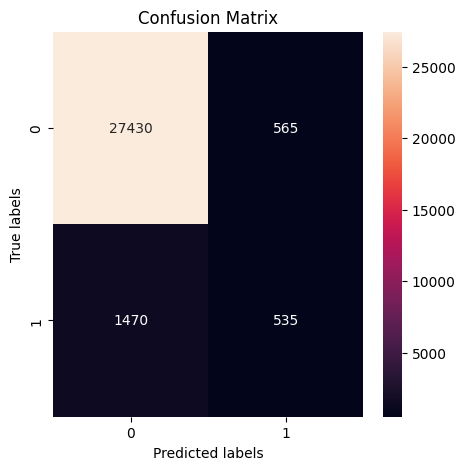

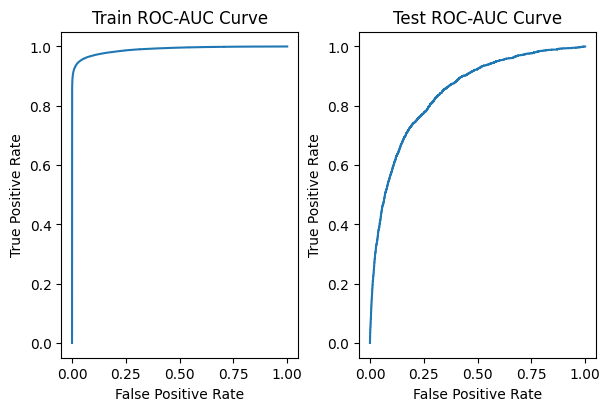

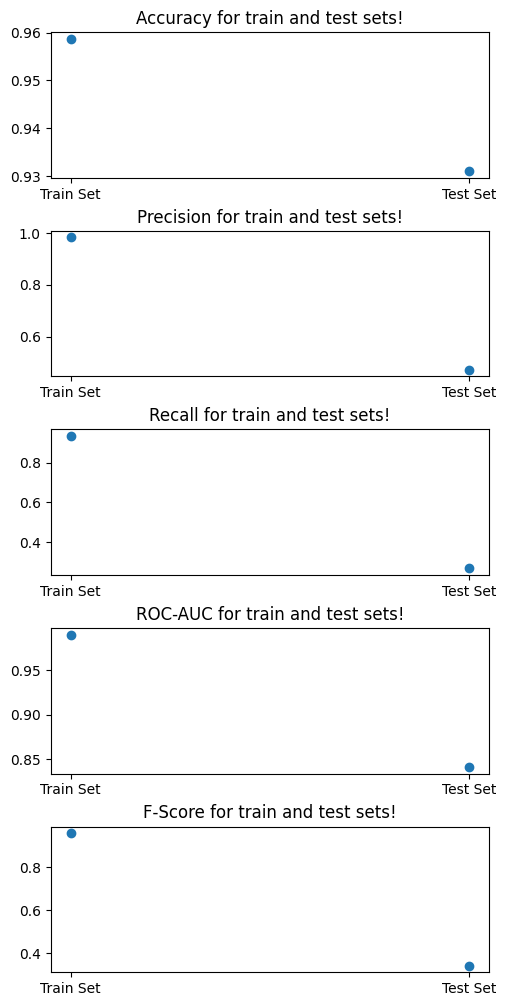

In [26]:
# Training and evaluating an XGBoost classifier here
xgb_clf, xgb_results = train_eval_classifier(XGBClassifier(n_estimators=100), X,y, False )


In [43]:
eli5.show_weights(xgb_clf, top= 20, feature_names = list(X.columns))


### Tuning XGBoost

In [27]:
# We are taking the baseline XGB Model that we trained and we will be tuning it using grid search
# Later on we again check the results on our tuned model

# A parameter grid for XGBoost
xgb_grid = { 'max_depth': [5,6,7,8, 9],
                 'learning_rate' : [0.01,0.02,0.03],
                  'num_iterations'    : [100, 200, 500, 1000]
                 }

xgb_opt = gridsearchit(xgb_clf, xgb_grid, X_train, X_test, y_train, y_test)

[17:18:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Results from Grid Search: 

The best estimator across ALL searched params for XGBClassifier
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_iterations=100,
              num_parallel_tr

### Evaluating Optimized XGBoost:

[17:19:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:  1  done
[17:19:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:  2  done
[17:19:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:  3  done
[17:19:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:  4  done
[17:19:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:

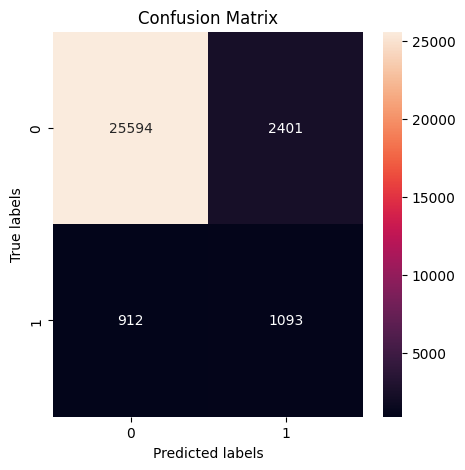

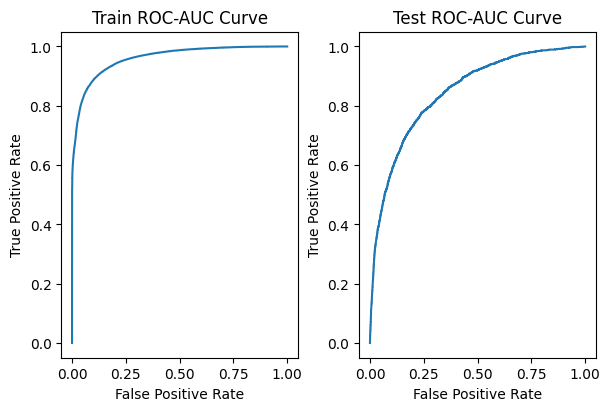

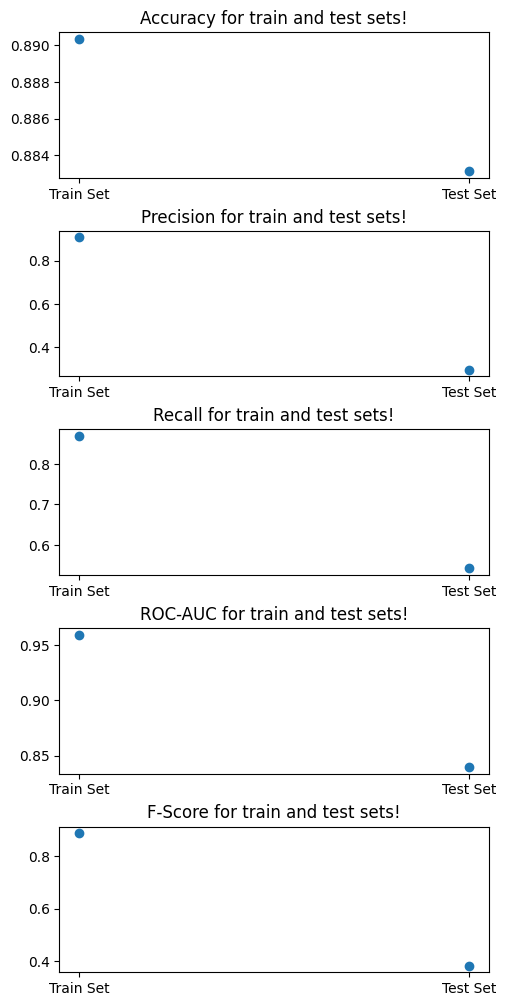

In [28]:
xgb_opt, xgb_opt_results = train_eval_classifier(xgb_opt, X,y, True )


In [42]:
eli5.show_weights(xgb_opt, top= 20, feature_names = list(X.columns))


### Random Forest Baseline Model

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.9997838884013317
Mean Accuracy on test set is:  0.9157933333333335

Mean Precision on train set is: 0.9997553286946891
Mean Precision on test set is: 0.36301991778314624

Mean Recall on train set is: 0.9998124652040005
Mean Recall on test set is: 0.34380593879210253

Mean F score on train set is: 0.9997838950440101
Mean F score on test set is: 0.3531134343224884

Mean Train ROC is: 0.999985144018822
Mean Test ROC is: 0.8255734792425689


Total time taken: 162.5137460231781


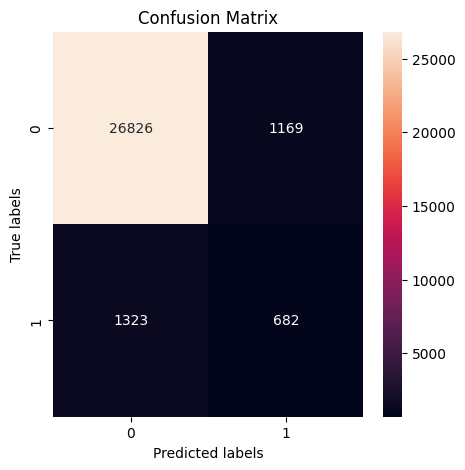

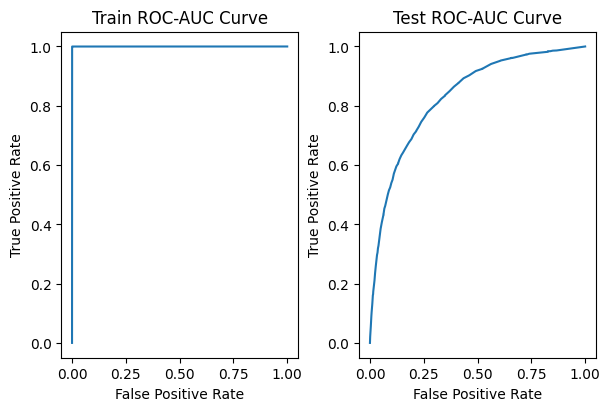

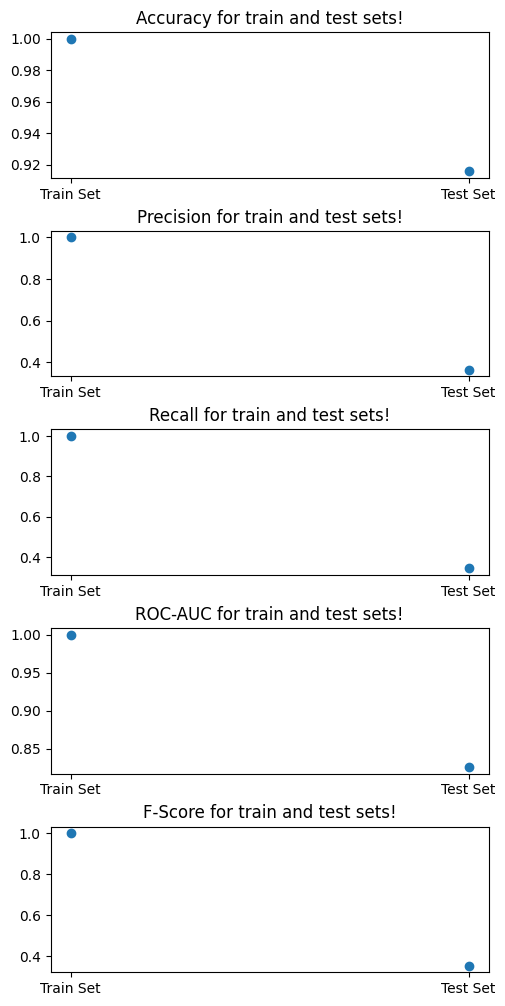

In [29]:
# Training and evaluating Random Forest classifier here
rf_clf, rf_results = train_eval_classifier(RandomForestClassifier(random_state = 0), X,y, False )


In [44]:
eli5.show_weights(rf_clf, top= 20, feature_names = list(X.columns))


### Tuning Random Forest

In [30]:
# We are taking the baseline RF Model that we trained and we will be tuning it using grid search
# Later on we again check the results on our tuned model

# A parameter grid for XGBoost
rf_grid = { 'max_depth': [5,6,7,8, 9]}

rf_opt = gridsearchit(rf_clf, rf_grid, X_train, X_test, y_train, y_test)

Results from Grid Search: 

The best estimator across ALL searched params for RandomForestClassifier
 RandomForestClassifier(max_depth=9, random_state=0)

The best score across ALL searched params for RandomForestClassifier 0.9283884596306777

The best parameters across ALL searched params for RandomForestClassifier:
 {'max_depth': 9}



### Evaluating Optimized Random Forest:

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.8447836733034653
Mean Accuracy on test set is:  0.8434533333333334

Mean Precision on train set is: 0.8544888403470914
Mean Precision on test set is: 0.2505417068517694

Mean Recall on train set is: 0.8310989857047817
Mean Recall on test set is: 0.6739472355999333

Mean F score on train set is: 0.8426297162339786
Mean F score on test set is: 0.365272991698463

Mean Train ROC is: 0.9312407414702901
Mean Test ROC is: 0.8532272399049642


Total time taken: 89.79858684539795


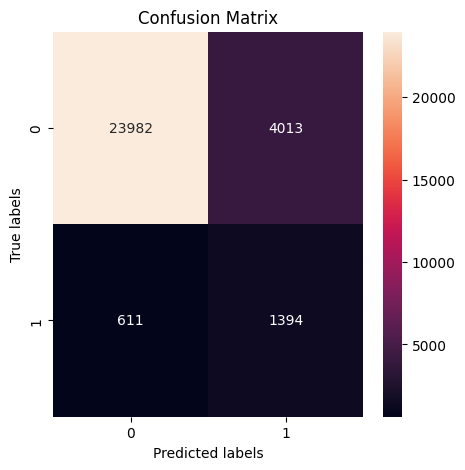

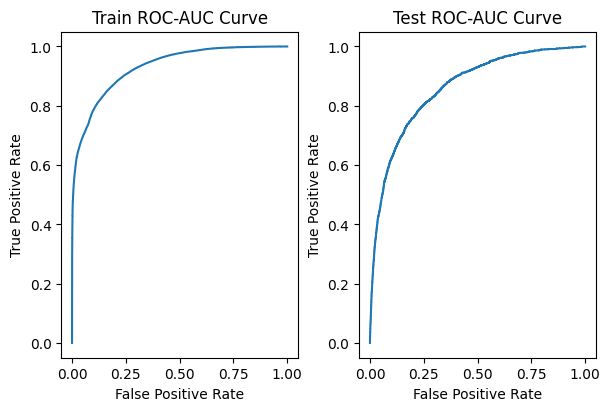

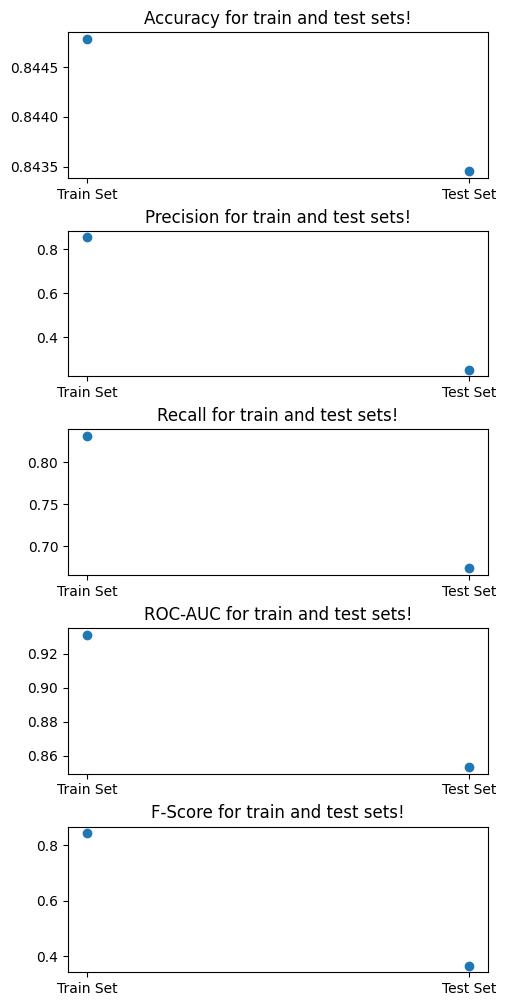

In [31]:
rf_opt, rf_opt_results = train_eval_classifier(rf_opt, X,y, True )


In [45]:
eli5.show_weights(rf_opt, top= 20, feature_names = list(X.columns))


### LR Baseline Model

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.7048308922854274
Mean Accuracy on test set is:  0.7467266666666666

Mean Precision on train set is: 0.7266058119315622
Mean Precision on test set is: 0.16047002946731662

Mean Recall on train set is: 0.6568594924512395
Mean Recall on test set is: 0.6587878260480404

Mean F score on train set is: 0.6899587457307348
Mean F score on test set is: 0.25806002041326653

Mean Train ROC is: 0.7815433268571962
Mean Test ROC is: 0.7812096233922771


Total time taken: 4.519613027572632


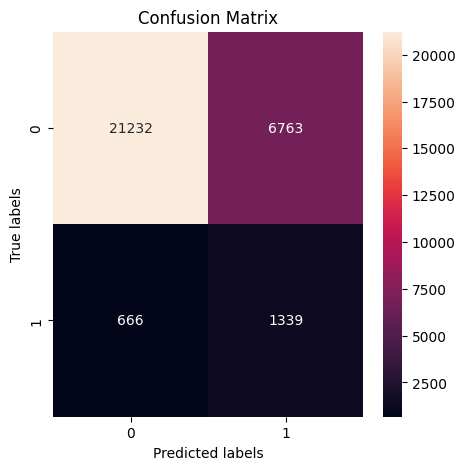

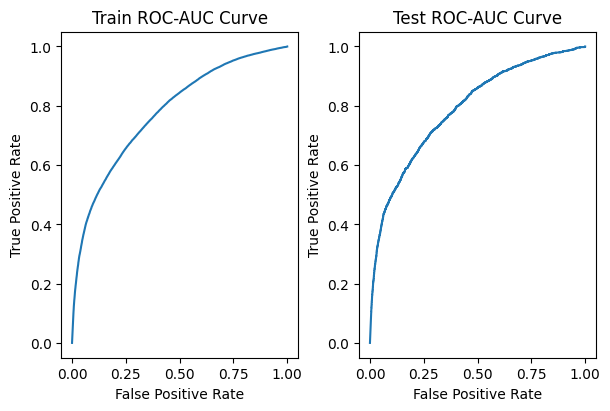

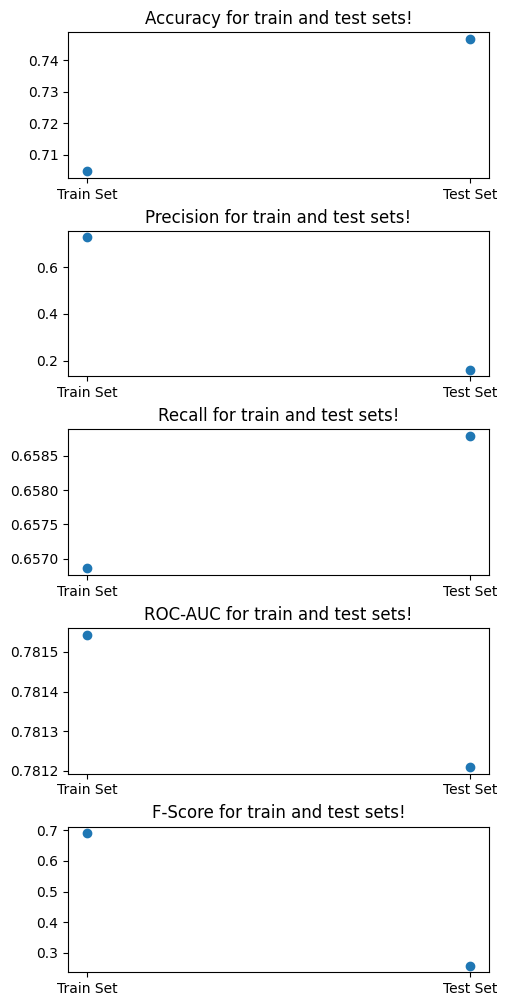

In [32]:
# Training and evaluating Logistic Regression classifier here
lr_clf, lr_results = train_eval_classifier(LogisticRegression(random_state = 0), X,y, False )


In [46]:
eli5.show_weights(lr_clf, top= 20, feature_names = list(X.columns))


## Final Model Results

In [33]:
All_Models = pd.concat([lr_results,dt_results,dt_opt_results, xgb_results, xgb_opt_results, rf_results, rf_opt_results])
All_Models

accuracy_train  accuracy_test  \
model_name                                                        
LogisticRegression                      0.704831       0.746727   
DecisionTreeClassifier                  0.999795       0.862440   
DecisionTreeClassifier_optimized        0.871390       0.853187   
XGBClassifier                           0.958714       0.931013   
XGBClassifier_optimized                 0.890350       0.883140   
RandomForestClassifier                  0.999784       0.915793   
RandomForestClassifier_optimized        0.844784       0.843453   

                                  precision_train  precision_test  \
model_name                                                          
LogisticRegression                       0.726606        0.160470   
DecisionTreeClassifier                   0.999848        0.195375   
DecisionTreeClassifier_optimized         0.886513        0.232580   
XGBClassifier                            0.982611        0.472112   
XGBClassifier_optimized                  0.908029        0.296217   
RandomForestClassifier                   0.999755        0.363020   
RandomForestClassifier_optimized         0.854489        0.250542   

                                  recall_train  recall_test  f1_train  \
model_name                                                              
LogisticRegression                    0.656859     0.658788  0.689959   
DecisionTreeClassifier                0.999743     0.339120  0.999795   
DecisionTreeClassifier_optimized      0.852046     0.517152  0.868848   
XGBClassifier                         0.933956     0.267306  0.957666   
XGBClassifier_optimized               0.868710     0.542290  0.887925   
RandomForestClassifier                0.999812     0.343806  0.999784   
RandomForestClassifier_optimized      0.831099     0.673947  0.842630   

                                   f1_test  roc_train  roc_test  
model_name                                                       
LogisticRegression                0.258060   0.781543  0.781210  
DecisionTreeClassifier            0.247911   1.000000  0.619921  
DecisionTreeClassifier_optimized  0.320406   0.950428  0.761700  
XGBClassifier                     0.341245   0.989744  0.841241  
XGBClassifier_optimized           0.383039   0.959582  0.839658  
RandomForestClassifier            0.353113   0.999985  0.825573  
RandomForestClassifier_optimized  0.365273   0.931241  0.853227

## Predicting on the test CSV

In [35]:
testing_data_X = testing_data.drop("SeriousDlqin2yrs", axis = 1)
testing_data_X_smote = scaler.transform(testing_data_X)


In [38]:
testing_data["SeriousDlqin2yrs"] = xgb_opt.predict(testing_data_X_smote)
testing_data

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                      1                              0.885519   43   
2                      1                              0.463295   57   
3                      1                              0.043275   59   
4                      1                              0.280308   38   
5                      1                              1.000000   27   
...                  ...                                   ...  ...   
101499                 1                              0.282653   24   
101500                 1                              0.922156   36   
101501                 1                              0.081596   70   
101502                 1                              0.335457   56   
101503                 1                              0.441842   29   

        NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
1                                          0     0.177513         5700.0   
2                                          0     0.527237         9141.0   
3                                          0     0.687648         5083.0   
4                                          1     0.925961         3200.0   
5                                          0     0.019917         3865.0   
...                                      ...          ...            ...   
101499                                     0     0.068522         1400.0   
101500                                     3     0.934217         7615.0   
101501                                     0   836.000000            NaN   
101502                                     0  3568.000000            NaN   
101503                                     0     0.198918         5916.0   

        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                                     4                        0   
2                                    15                        0   
3                                    12                        0   
4                                     7                        0   
5                                     4                        0   
...                                 ...                      ...   
101499                                5                        0   
101500                                8                        0   
101501                                3                        0   
101502                                8                        0   
101503                               12                        0   

        NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                                  0                                     0   
2                                  4                                     0   
3                                  1                                     0   
4                                  2                                     0   
5                                  0                                     0   
...                              ...                                   ...   
101499                             0                                     0   
101500                             2                                     0   
101501                             0                                     0   
101502                             2                                     1   
101503                             0                                     0   

        NumberOfDependents  
1                      0.0  
2                      2.0  
3                      2.0  
4                      0.0  
5                      1.0  
...                    ...  
101499                 0.0  
101500                 4.0  
101501                 NaN  
101502                 3.0  
101503                 0.0  

[101503 rows x 11 columns]

## Conclusion


> There were some null values in data which were dealt using median imputation.

> Feature range was not same due to which we performed scaling.

> There was class imbalance in data, we performed balancing using SMOTE.

> Scores on Baseline models have been found out using 5 folds to get an averaged result. Following which we optimzed model using grid search on a single train test split then again this optimized model has been sent through k fold to get the final result.

> To avoid data leakage, data has been fitted and transformed on train dataset and on test set it has been just transformed.

> We are taking into consideration ROC-AUC to choose our final model as this is a classification task. ROC auc takes into consideration not one but multiple thresholds.

> ROC AUC gives Logistic regression to be the most stable model out of all. The train and test scores are very close and they are neither underfitting nor overfitting.

> RevolvingUtilizationOfUnsecuredLines and NumberOfTime30-59DaysPastDueNotWorse comes up to be the most important features for almost all models.